### Считывание кластеризованных данных

In [1]:
import os
import pandas as pd

os.chdir('../../../')

In [15]:
df = pd.read_csv('data/lmsys-chat-1m/processed/kmeans_clusters.csv')
df.head()

,user_id,neutral_count,positive_count,negative_count,total_reformulations,total_words,total_spelling_errors,total_questions,cluster
0,0,0.000000,1.0,0.000000,0.0,11.0,0.0,0.000000,1
1,1,0.333333,0.5,0.166667,0.5,25.0,0.5,0.666667,1
2,2,0.000000,1.0,0.000000,0.0,66.0,0.0,0.000000,1
3,3,0.500000,0.5,0.000000,0.0,14.5,0.0,0.000000,0
4,4,1.000000,0.0,0.000000,0.0,18.0,3.0,0.000000,0


### Обучение классификатора

In [16]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from scipy.stats import randint, uniform
import time

X = df.drop(['user_id', 'cluster'], axis=1)
y = df['cluster']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

param_dist_lgb = {
    'n_estimators': randint(100, 500),
    'max_depth': [-1] + list(range(3, 15)),
    'learning_rate': uniform(0.01, 0.2),
    'num_leaves': randint(20, 150),
    'min_child_samples': randint(5, 50),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

model_lgb = LGBMClassifier(random_state=42)

search_lgb = RandomizedSearchCV(
    model_lgb,
    param_distributions=param_dist_lgb,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

start = time.time()
search_lgb.fit(X_train, y_train)
end = time.time()

print(f"LightGBM — лучшая модель: {search_lgb.best_params_}")
print(f"Время подбора: {round(end - start, 2)} сек")

best_model = search_lgb.best_estimator_
y_pred = best_model.predict(X_test)

print("Качество (LightGBM):")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1073
[LightGBM] [Info] Number of data points in the train set: 103731, number of used features: 7
[LightGBM] [Info] Start training from score -0.818609
[LightGBM] [Info] Start training from score -1.112797
[LightGBM] [Info] Start training from score -4.382518
[LightGBM] [Info] Start training from score -2.530619
[LightGBM] [Info] Start training from score -2.046397
[LightGBM] [Info] Start training from score -4.709010
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

### Проверка на переобучение

In [17]:
train_acc = best_model.score(X_train, y_train)
test_acc = best_model.score(X_test, y_test)
print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy:  {test_acc:.4f}")

Train accuracy: 0.9999
Test accuracy:  0.9981


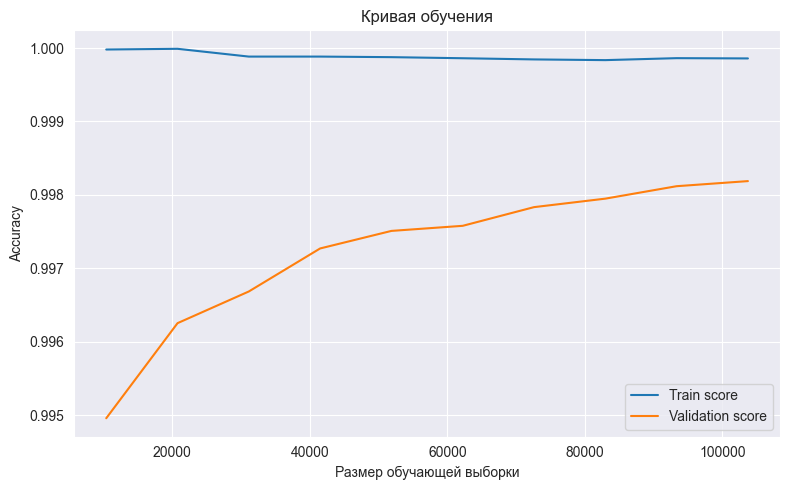

In [18]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label='Train score')
plt.plot(train_sizes, test_mean, label='Validation score')
plt.xlabel("Размер обучающей выборки")
plt.ylabel("Accuracy")
plt.title("Кривая обучения")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Сохраняем модель

In [19]:
import joblib

joblib.dump(best_model, 'models/gradient_boosting/model_lightgbm.pkl')

['models/gradient_boosting/model_lightgbm.pkl']

### Проверка без дубликатов

In [20]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from scipy.stats import randint, uniform
import time

X = df.drop(['user_id', 'cluster'], axis=1)
y = df['cluster']
X = X.drop_duplicates()
y = y.loc[X.index]  # пересинхронизация y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

param_dist_lgb = {
    'n_estimators': randint(100, 500),
    'max_depth': [-1] + list(range(3, 15)),
    'learning_rate': uniform(0.01, 0.2),
    'num_leaves': randint(20, 150),
    'min_child_samples': randint(5, 50),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

model_lgb = LGBMClassifier(random_state=42)

search_lgb = RandomizedSearchCV(
    model_lgb,
    param_distributions=param_dist_lgb,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

start = time.time()
search_lgb.fit(X_train, y_train)
end = time.time()

print(f"LightGBM — лучшая модель: {search_lgb.best_params_}")
print(f"Время подбора: {round(end - start, 2)} сек")

best_model = search_lgb.best_estimator_
y_pred = best_model.predict(X_test)

print("Качество (LightGBM):")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1152
[LightGBM] [Info] Number of data points in the train set: 31591, number of used features: 7
[LightGBM] [Info] Start training from score -0.936386
[LightGBM] [Info] Start training from score -1.406212
[LightGBM] [Info] Start training from score -3.445897
[LightGBM] [Info] Start training from score -1.874512
[LightGBM] [Info] Start training from score -1.888641
[LightGBM] [Info] Start training from score -3.637998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

### Проверка на переобучение

In [21]:
train_acc = best_model.score(X_train, y_train)
test_acc = best_model.score(X_test, y_test)
print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy:  {test_acc:.4f}")

Train accuracy: 0.9998
Test accuracy:  0.9935


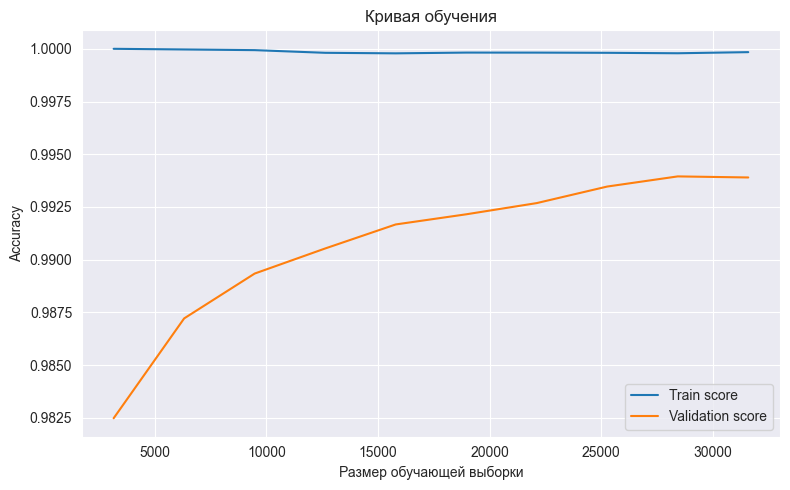

In [22]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label='Train score')
plt.plot(train_sizes, test_mean, label='Validation score')
plt.xlabel("Размер обучающей выборки")
plt.ylabel("Accuracy")
plt.title("Кривая обучения")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Сохраняем модель

In [23]:
import joblib

joblib.dump(best_model, 'models/gradient_boosting/model_lightgbm_wo_duplicates.pkl')

['models/gradient_boosting/model_lightgbm_wo_duplicates.pkl']